In [ ]:
!pip install torchray

In [2]:
# Commented out IPython magic to ensure Python compatibility.
import matplotlib.pyplot as plt
import numpy as np

# %matplotlib inline

import torch
import torchvision

from torch import nn
from torch import optim

from torchvision import models, datasets
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
from torch.nn import functional as F
from torchray.benchmark import get_example_data, plot_example
from torchray.utils import imsc

# Default device
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(device)

cuda:0


In [3]:
resModel = models.segmentation.fcn_resnet101(pretrained=True).to(device).eval()

In [4]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = resModel.backbone.conv1
        self.bn1 = resModel.backbone.bn1
        self.relu1 = nn.ReLU(inplace=False)
        self.maxpool1 = resModel.backbone.maxpool
        self.layer1 = resModel.backbone.layer1
        self.layer2 = resModel.backbone.layer2
        self.layer3 = resModel.backbone.layer3
        self.layer4 = resModel.backbone.layer4
        self.layer5 = resModel.classifier
        #self.layer6 = resModel.aux_classifier

    def forward(self, x):
        input_shape = x.shape[-2:]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = F.interpolate(x, size=input_shape, mode='bilinear', align_corners=False)
        op_max = torch.argmax(x,dim=1, keepdim=True)
        selected_inds = torch.zeros_like(x[0:]).scatter_(1, op_max, 1)
        return (x * selected_inds).sum(dim=(2,3))

        #return self.layer6(x)  
        #return x

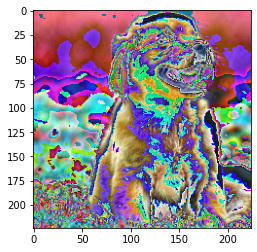

In [7]:
copyNet = Net()

# declaring transform
from torchvision import datasets
data_transform = transforms.Compose([
        transforms.Resize(256),                            
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean = [0.485, 0.456, 0.406],
                            std = [0.229, 0.224, 0.225])
])

from PIL import Image
trans = transforms.ToPILImage()
trans1 = transforms.ToTensor()

copyNet.to(device).eval()
copyNet.layer5[4]

img = Image.open("dog.jpg")
plt.imshow(trans(data_transform(img)))
ip= torch.unsqueeze(data_transform(img).to(device), 0)

In [9]:
#RISE
def torchray_Rise(model,input_image,category_id):
  from torchray.attribution.rise import rise

  # RISE method.
  saliency = rise(model, input_image)
  saliency = saliency[:, category_id].unsqueeze(0)

  # Plots.
  plt.subplot(1,2,1)
  imsc(input_image[0])
  plt.title('Input image', fontsize=8)

  plt.subplot(1,2,2)
  imsc(saliency[0], interpolation='none')
  plt.title("Output", fontsize=8)

  plt.show()

In [10]:
#DeConvNet
def torchray_Deconv(model,input_image,category_id):
  from torchray.attribution.deconvnet import deconvnet
  saliency = deconvnet(model, input_image, category_id)

  # Plots.
  plt.subplot(1,2,1)
  imsc(input_image[0])
  plt.title('Input image', fontsize=8)

  plt.subplot(1,2,2)
  imsc(saliency[0], interpolation='none')
  plt.title("Output", fontsize=8)

  plt.show()

In [17]:
#Grad cam
def torchray_Gradcam(model,input_image,category_id,layer):
  from torchray.attribution.grad_cam import grad_cam
  saliency = grad_cam(model, input_image, category_id, saliency_layer=layer)

  # Plots.
  plt.subplot(1,2,1)
  imsc(input_image[0])
  plt.title('Input image', fontsize=8)

  plt.subplot(1,2,2)
  imsc(saliency[0], interpolation='none')
  plt.title("Output", fontsize=8)

  plt.show()

In [18]:
#Gradient
from torchray.attribution.gradient import gradient
def torchray_Gradient(model,input_image,category_id):
  # Gradient method.
  saliency = gradient(model, input_image, category_id)

  # Plots.
  plt.clf()
  plt.subplot(1,2,1)
  #plt.imshow(input_image)
  imsc(input_image[0])
  plt.title('Input image', fontsize=8)

  plt.subplot(1,2,2)
  imsc(saliency[0], interpolation='none')
  plt.title("Output", fontsize=8)

  plt.show()

In [19]:
#Guided backpropagation
def torchray_Guidedbackprop(model,input_image,category_id):
  from torchray.attribution.guided_backprop import guided_backprop

  # Guided backprop.
  saliency = guided_backprop(model, input_image, category_id)

  # Plots.
  plt.clf()
  plt.subplot(1,2,1)
  #plt.imshow(input_image)
  imsc(input_image[0])
  plt.title('Input image', fontsize=8)

  plt.subplot(1,2,2)
  imsc(saliency[0], interpolation='none')
  plt.title("Output", fontsize=8)

  plt.show()

In [20]:
#Linear Approximator
def torchray_Linearapprox(model,input_image,category_id,layer):
  from torchray.attribution.linear_approx import linear_approx

  # Linear approximation backprop.
  saliency = linear_approx(model, input_image, category_id, saliency_layer=layer)

  # Plots.
  plt.clf()
  plt.subplot(1,2,1)
  #plt.imshow(input_image)
  imsc(input_image[0])
  plt.title('Input image', fontsize=8)

  plt.subplot(1,2,2)
  imsc(saliency[0], interpolation='none')
  plt.title("Output", fontsize=8)

  plt.show()

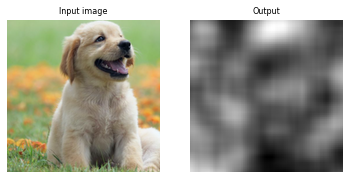

In [127]:
torchray_Rise(copyNet,ip,12)

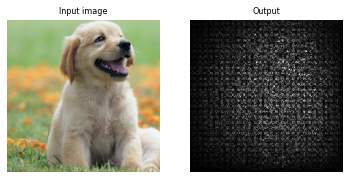

In [21]:
torchray_Deconv(copyNet,ip,12)

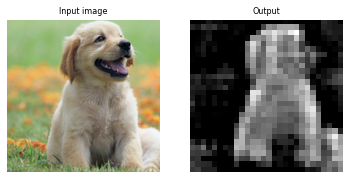

In [22]:
torchray_Gradcam(copyNet,ip,12,'layer3')

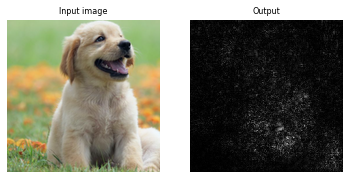

In [23]:
torchray_Gradient(copyNet,ip,12)

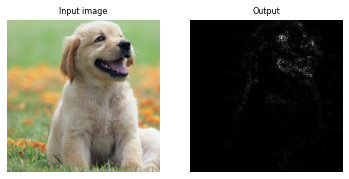

In [24]:
torchray_Guidedbackprop(copyNet,ip,12)

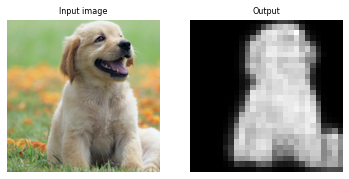

In [25]:
torchray_Linearapprox(copyNet,ip,12,'layer4')

In [ ]:
{ 
  "model_nature" : "Segmentation",
  "model_name" : "FCN_Resnet101",
  "dataset" : "coco",
  "test_run" : "test1",
  "resize" : 120,
  "centre_crop" : 120,
  "mean_vec" : [0.485, 0.456, 0.406],
  "std_vec" :  [0.229, 0.224, 0.225],
  "methods" : [   
                     { "method_name" : "torchray_Rise",  
                       "library" : "torchray",
                       "inpt_transform_req" : true,
                       "target" : [12],
                       "aux_func_flag" : true,
                       "visualize_method" : "heat_map",
                       "sign": "all",
                       "show_colorbar": True,
                       "title" : "Rise",
                       "device_id" : "cuda:0",
                     }

In [ ]:
{ 
  "model_nature" : "Segmentation",
  "model_name" : "FCN_Resnet101",
  "dataset" : "coco",
  "test_run" : "test1",
  "resize" : 120,
  "centre_crop" : 120,
  "mean_vec" : [0.485, 0.456, 0.406],
  "std_vec" :  [0.229, 0.224, 0.225],
  "methods" : [   
                     { "method_name" : "torchray_Deconv",  
                       "library" : "torchray",
                       "inpt_transform_req" : true,
                       "target" : [12],
                       "aux_func_flag" : true,
                       "visualize_method" : "heat_map",
                       "sign": "all",
                       "show_colorbar": True,
                       "title" : "Deconvolution",
                       "device_id" : "cuda:0",
                     }

In [ ]:
{ 
  "model_nature" : "Segmentation",
  "model_name" : "FCN_Resnet101",
  "dataset" : "coco",
  "test_run" : "test1",
  "resize" : 120,
  "centre_crop" : 120,
  "mean_vec" : [0.485, 0.456, 0.406],
  "std_vec" :  [0.229, 0.224, 0.225],
  "methods" : [   
                     { "method_name" : "torchray_Gradcam",  
                       "library" : "torchray",
                       "inpt_transform_req" : true,
                       "target" : [12],
                       "aux_func_flag" : true,
                       "visualize_method" : "heat_map",
                       "sign": "all",
                       "show_colorbar": True,
                       "title" : "GradCam",
                       "device_id" : "cuda:0",
                       "keywords": {"cnn layer": layer4}
                     }

In [ ]:
{ 
  "model_nature" : "Segmentation",
  "model_name" : "FCN_Resnet101",
  "dataset" : "coco",
  "test_run" : "test1",
  "resize" : 120,
  "centre_crop" : 120,
  "mean_vec" : [0.485, 0.456, 0.406],
  "std_vec" :  [0.229, 0.224, 0.225],
  "methods" : [   
                     { "method_name" : "torchray_Gradient",  
                       "library" : "torchray",
                       "inpt_transform_req" : true,
                       "target" : [12],
                       "aux_func_flag" : true,
                       "visualize_method" : "heat_map",
                       "sign": "all",
                       "show_colorbar": True,
                       "title" : "Gradient",
                       "device_id" : "cuda:0",
                     }

In [ ]:
{ 
  "model_nature" : "Segmentation",
  "model_name" : "FCN_Resnet101",
  "dataset" : "coco",
  "test_run" : "test1",
  "resize" : 120,
  "centre_crop" : 120,
  "mean_vec" : [0.485, 0.456, 0.406],
  "std_vec" :  [0.229, 0.224, 0.225],
  "methods" : [   
                     { "method_name" : "torchray_Guidedbackprop",  
                       "library" : "torchray",
                       "inpt_transform_req" : true,
                       "target" : [12],
                       "aux_func_flag" : true,
                       "visualize_method" : "heat_map",
                       "sign": "all",
                       "show_colorbar": True,
                       "title" : "Guidedbackprop",
                       "device_id" : "cuda:0",
                     }

In [ ]:
{ 
  "model_nature" : "Segmentation",
  "model_name" : "FCN_Resnet101",
  "dataset" : "coco",
  "test_run" : "test1",
  "resize" : 120,
  "centre_crop" : 120,
  "mean_vec" : [0.485, 0.456, 0.406],
  "std_vec" :  [0.229, 0.224, 0.225],
  "methods" : [   
                     { "method_name" : "torchray_Linearapprox",  
                       "library" : "torchray",
                       "inpt_transform_req" : true,
                       "target" : [12],
                       "aux_func_flag" : true,
                       "visualize_method" : "heat_map",
                       "sign": "all",
                       "show_colorbar": True,
                       "title" : "LinearApproximation",
                       "device_id" : "cuda:0",
                       "keywords": {"cnn layer": layer4}
                     }